In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from fastai import *
from fastai.vision import *

from glob import glob
import seaborn as sns

%matplotlib inline

%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

seed = 12345

/content/drive/My Drive/alfalfa-convnets


# RAdam

Taken directly from the [official implementation for RAdam](https://github.com/LiyuanLucasLiu/RAdam).

In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


# Training

In [0]:
bs = 128
sz = 224

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

# get Zgas closer to a median of 0
df.Zgas -= 8.8


src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols=['logfgas', 'logsSFR', 'logMstar', 'Zgas'],  label_cls=FloatList)
      )

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)

# stats computed from a single batch of SDSS images (xGASS)
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

# note that sometimes this times out because Google Drive has a limit on how many files can be processed at a time
data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(RAdam),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

In [0]:
learn.model[-1] = nn.Linear(512, 4, bias=True).cuda()
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,time
0,6.865568,6.945153,12:11


In [0]:
learn.fit_one_cycle(50, 1e-2)

epoch,train_loss,valid_loss,time
0,6.777728,6.710551,00:58
1,6.629496,6.386500,00:38
2,6.366712,5.939576,00:38
3,6.014307,5.497321,00:37
4,5.660398,5.155784,00:38
5,5.332851,4.829590,00:38
6,4.943893,4.338919,00:38
7,4.472684,3.707096,00:37
8,3.895453,3.193347,00:38
9,3.187226,2.049515,00:38


(0.2, 0.6)

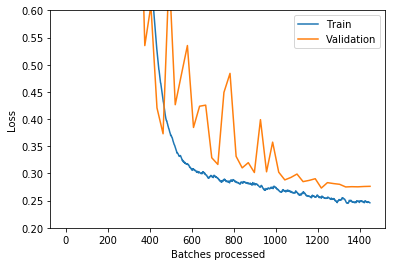

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

In [0]:
learn.save('a40_all-galaxy-properties_50ep-RAdam')
# learn.load('a40_all-galaxy-properties_50ep-RAdam');

In [0]:
tta_results = learn.TTA()

In [0]:
pred, targ = tta_results

In [0]:
(pred - targ).pow(2).mean(0).pow(0.5)

tensor([0.4284, 0.4440, 0.6617, 0.2415])

# Training (larger batch size, larger learning rate)

In [0]:
bs = 256
sz = 224

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

# get Zgas closer to a median of 0
df.Zgas -= 8.8


src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols=['logfgas', 'logsSFR', 'logMstar', 'Zgas'],  label_cls=FloatList)
      )

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)

# stats computed from a single batch of SDSS images (xGASS)
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

# note that sometimes this times out because Google Drive has a limit on how many files can be processed at a time
data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(RAdam),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 4, bias=True).cuda()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


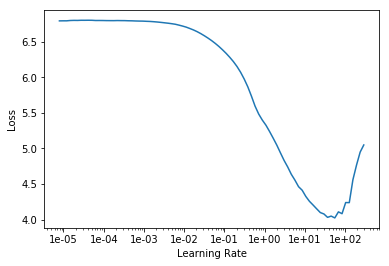

In [0]:
learn.lr_find(start_lr=1e-6, end_lr=1e3)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(50, 3e-2, pct_start=0.1)

epoch,train_loss,valid_loss,time
0,6.848739,6.762416,00:36
1,6.675576,6.173243,00:36
2,6.293347,5.763557,00:37
3,5.826498,4.629388,00:37
4,5.280758,4.055665,00:36
5,4.652758,3.168671,00:36
6,3.951324,2.141709,00:36
7,3.195436,0.832394,00:36
8,2.474278,0.928251,00:36
9,1.926558,0.941298,00:36


(0.2, 0.6)

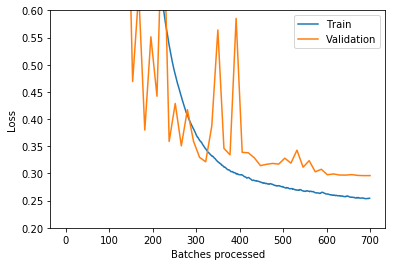

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

# Only predict $f_{\rm gas}$

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 128
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas',  'logsSFR', 'logMstar', 'Zgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(RAdam),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )
learn.model[-1] = nn.Linear(512, 4, bias=True).cuda()

learn.load('a40_all-galaxy-properties_50ep-RAdam');

In [0]:
# change data to only include logfgas
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
# add final layer
learn.model = nn.Sequential(*learn.model, nn.Linear(4, 1, bias=True)).cuda()

learn.data = data

Note that I'll need to re-run the below cells, and make sure that the validation/training sets don't get cross-contaminated when I do the "transfer" learning

In [0]:
# note that you can't do discriminative learning rates with xresnet (out of the box)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,2.751096,2.814606,00:37
1,1.205272,0.540320,00:38
2,0.712614,0.325903,00:38
3,0.500248,0.259227,00:38
4,0.388913,0.254714,00:37


In [0]:
tta_results = learn.TTA()
pred, targ = tta_results

display(root_mean_squared_error(pred, targ))

tensor(0.3127)

In [0]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.261465,0.252973,00:36
1,0.258695,0.253409,00:37
2,0.261746,0.253939,00:37
3,0.261013,0.263038,00:37
4,0.259895,0.254004,00:37
5,0.259199,0.249097,00:37
6,0.257658,0.252114,00:37
7,0.257153,0.249858,00:37
8,0.254452,0.250160,00:37
9,0.252182,0.249080,00:37


# Train a.40 $f_{\rm gas}$ from scratch

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 128
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(RAdam),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()


In [0]:
learn.fit_one_cycle(1, 1e-4, pct_start=1.)

epoch,train_loss,valid_loss,time
0,0.594071,0.532312,00:37


In [85]:
learn.fit_one_cycle(90, 1e-2)

epoch,train_loss,valid_loss,time
0,0.489258,0.444630,00:37
1,0.440044,0.387596,00:37
2,0.398352,0.339194,00:37
3,0.356448,0.306385,00:37
4,0.328060,0.300987,00:37
5,0.312229,0.419100,00:37
6,0.301370,0.376704,00:37
7,0.298873,0.280989,00:37
8,0.289319,0.275824,00:37
9,0.289257,0.634452,00:37


(0.2, 0.6)

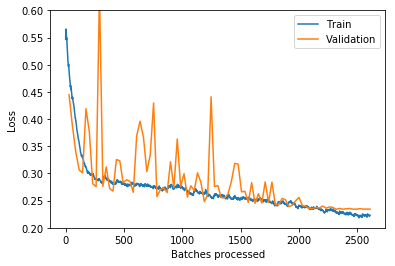

In [86]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

In [0]:
# learn.save('a40_fgas_90ep-RAdam-1');
learn.load('a40_fgas_90ep-RAdam-1');

In [11]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2249)

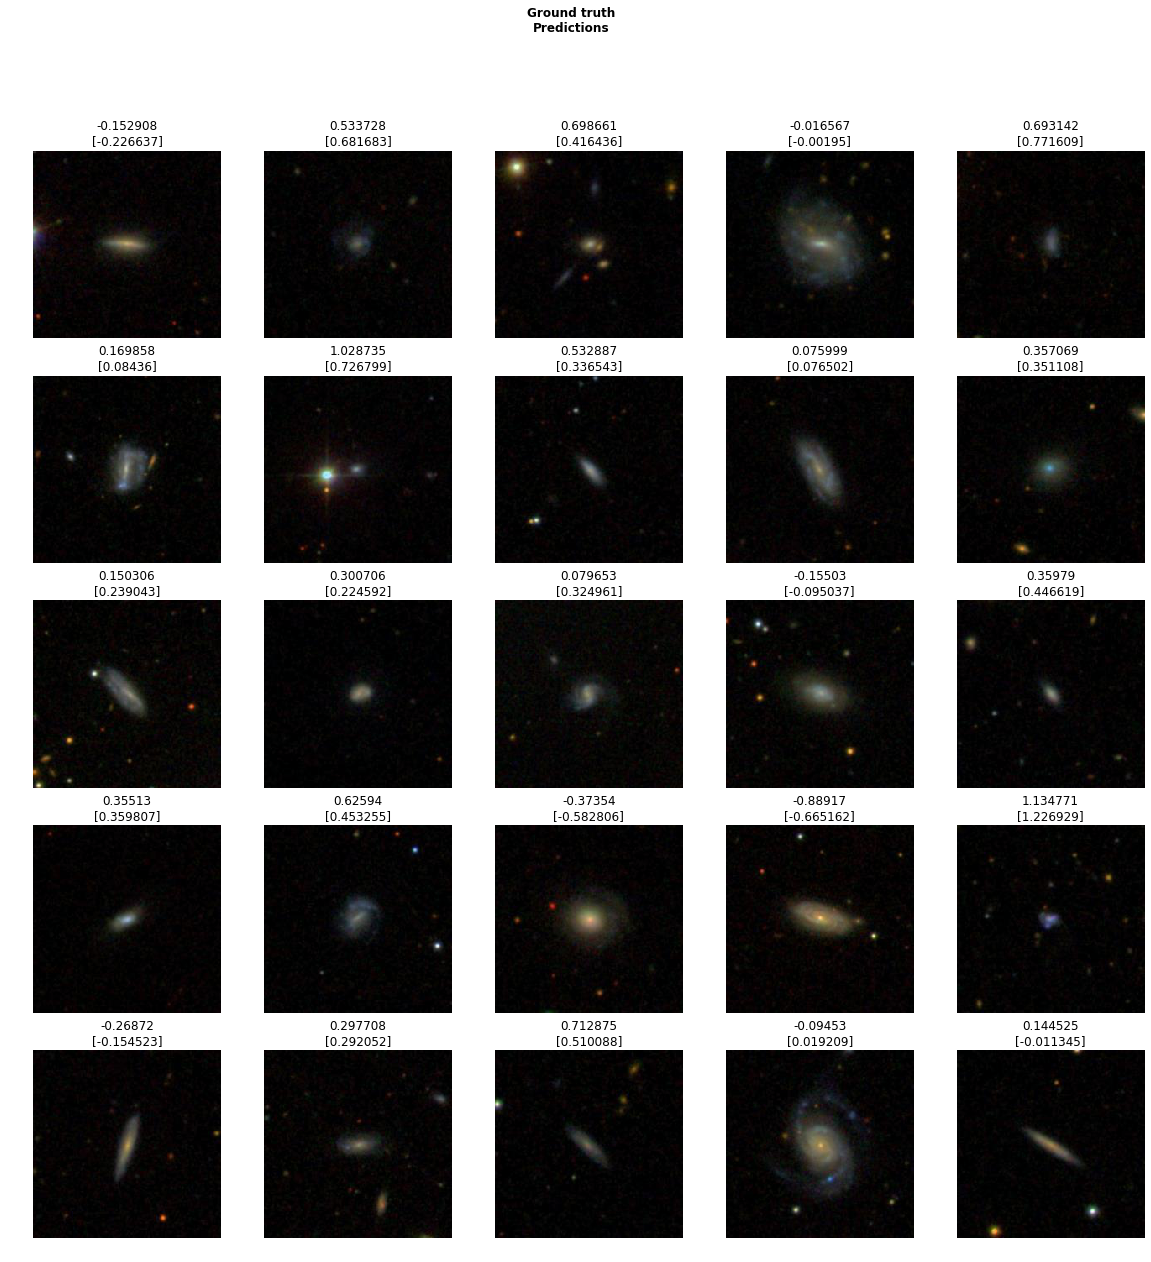

In [13]:
learn.show_results()

## Results

In [18]:
# store results, along with SDSS identifier, in new DataFrame
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,fgas_pred,fgas_true
AGCNr,,
712661,0.372553,0.395539
192140,0.223861,0.333741
202168,-0.358490,-0.322020


In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-OC/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('fgas_pred', 'fgas_true', data=results, c='black')

    if show_images:
        artists = []
        for objID, [fgas_pred, fgas_true] in results.sample(100).iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (fgas_true, fgas_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([-2, 2], [-2, 2], c='C3', ls='--', lw='10')

    ax.set_xlim(-1, 1.5)
    ax.set_ylim(-1, 1.5)
    ax.set_xlabel(r'True $f_{\rm gas}$')
    ax.set_ylabel(r'Pred $f_{\rm gas}$')



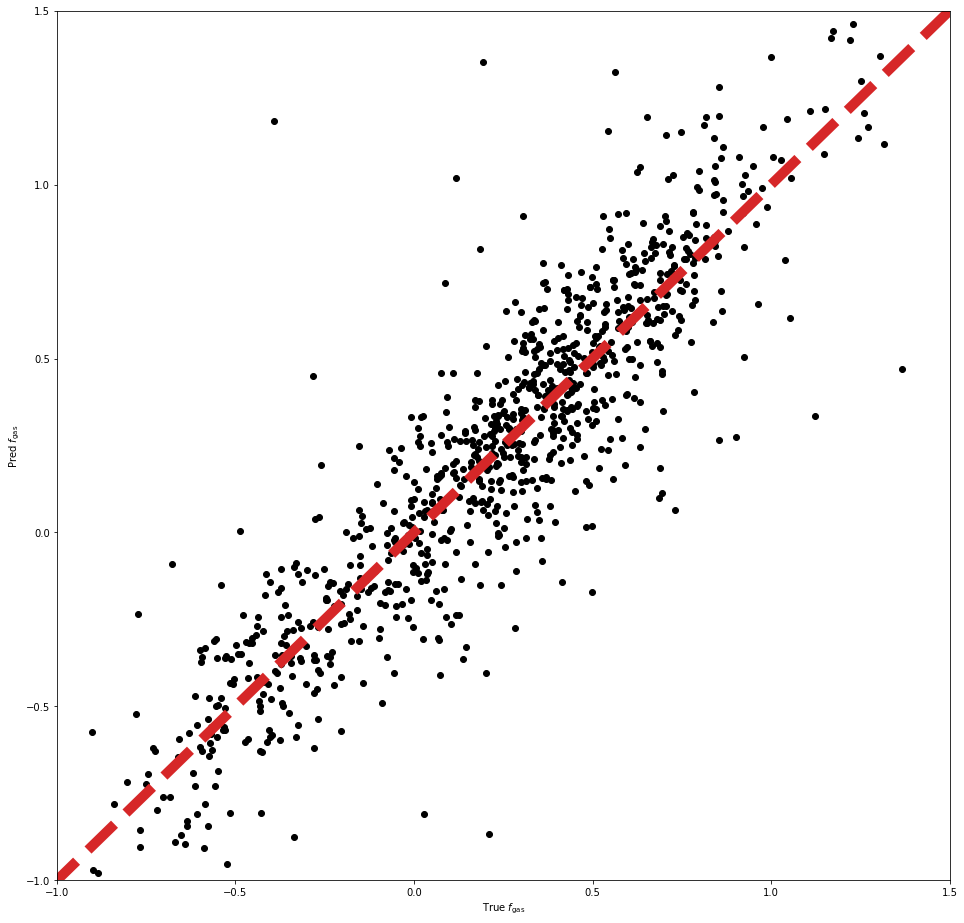

In [24]:
plot_results(results, show_images=False)

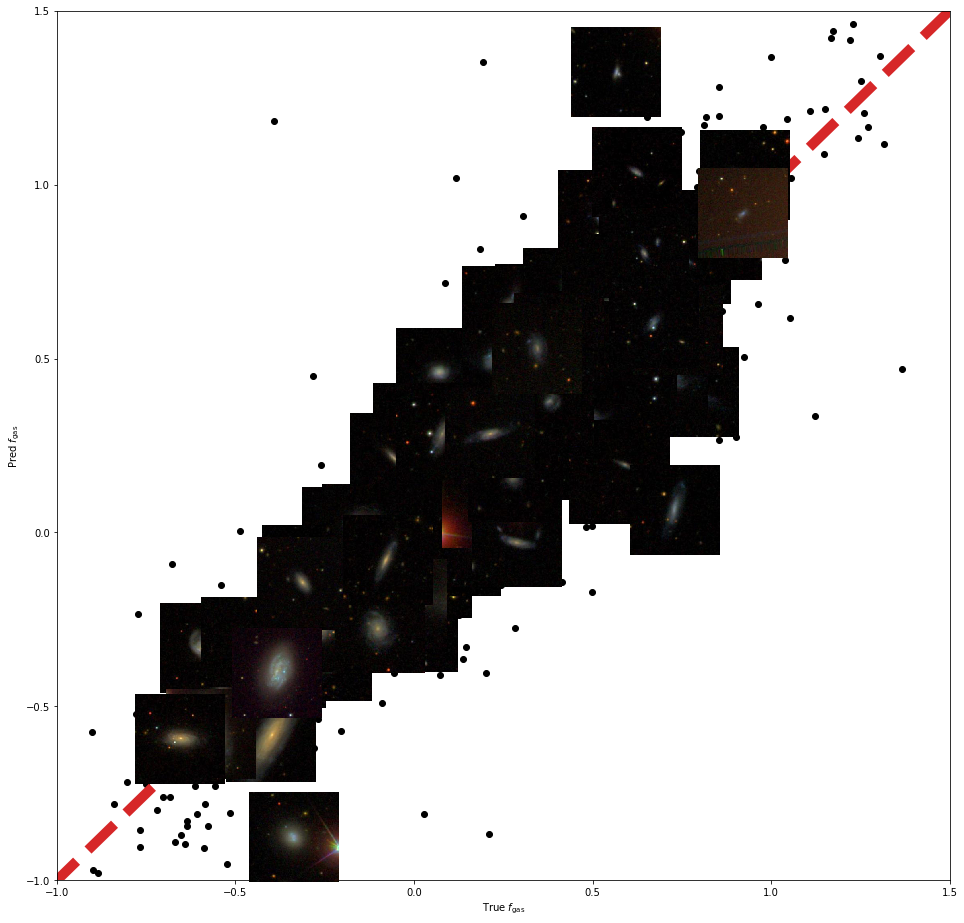

In [28]:
plot_results(results, show_images=True)

# Train again but start annealing early

In [2]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 128
sz = 224

NameError: ignored

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(RAdam),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()


In [92]:
learn.fit_one_cycle(1, 1e-4, pct_start=1.)

epoch,train_loss,valid_loss,time
0,0.521666,0.645828,00:37


In [93]:
learn.fit_one_cycle(90, 1e-2, pct_start=0.1)

epoch,train_loss,valid_loss,time
0,0.448839,0.435537,00:37
1,0.409064,0.388921,00:38
2,0.369334,0.345598,00:38
3,0.339326,0.385949,00:38
4,0.317815,0.332462,00:38
5,0.311609,0.562341,00:38
6,0.305277,0.707427,00:38
7,0.301037,0.586224,00:38
8,0.293524,0.335413,00:38
9,0.289036,0.325242,00:38


(0.2, 0.6)

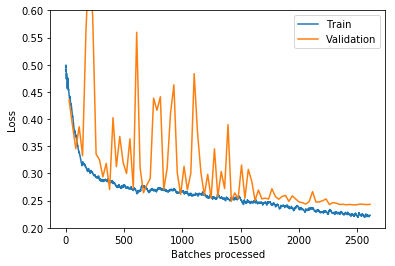

In [95]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.6)

In [0]:
# learn.save('a40_fgas_90ep-RAdam-1b');
learn.load('a40_fgas_90ep-RAdam-1b');

In [31]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2326)

In [0]:
# store results, along with SDSS identifier, in new DataFrame
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

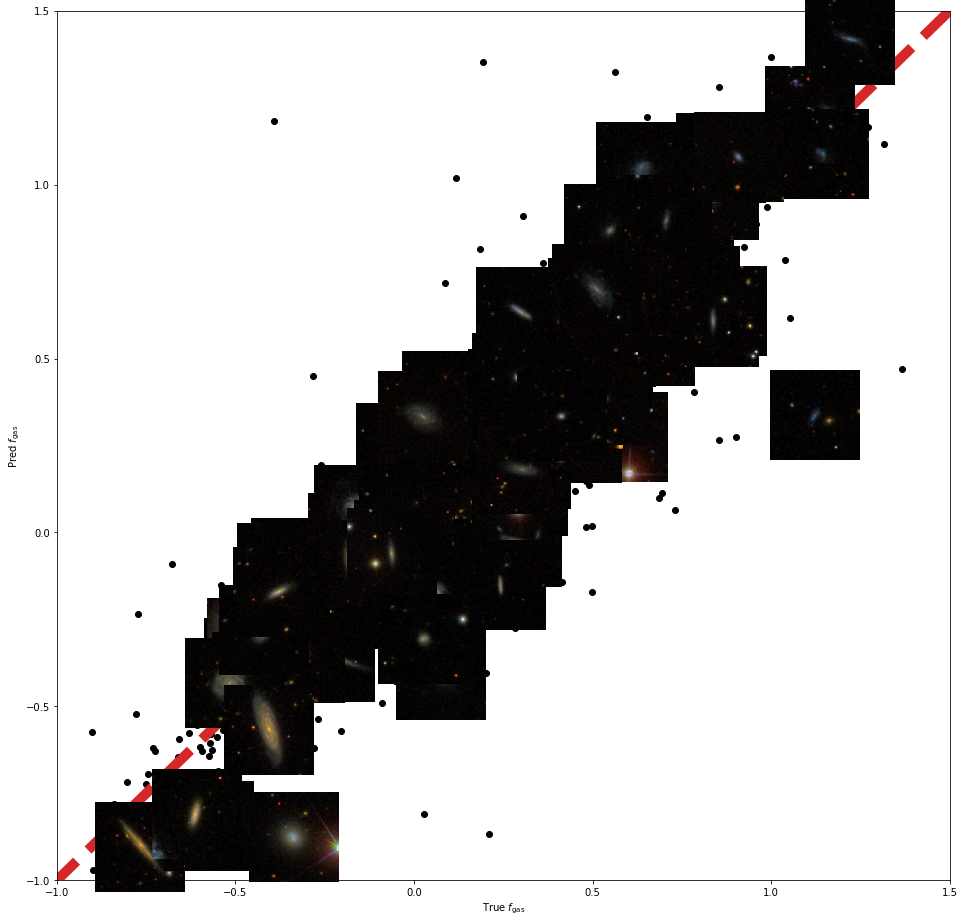

In [32]:
plot_results(results, show_images=True)

# Try only 15 epochs

In [0]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [0]:
learn = Learner(data, model=models.xresnet34(), 
                opt_func=partial(RAdam),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, 1, bias=True).cuda()


In [48]:
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,time
0,0.375434,0.380408,00:40
1,0.328939,0.392821,00:39
2,0.317348,0.408308,00:40
3,0.302032,0.320870,00:40
4,0.299170,0.425750,00:40
5,0.301506,0.342049,00:40
6,0.296380,0.280019,00:40
7,0.276750,0.344970,00:39
8,0.287934,0.315140,00:40
9,0.275967,0.299692,00:40


In [49]:
fgas_pred, fgas_true = learn.TTA(scale=1.)
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2636)

In [50]:
# store results, along with SDSS identifier, in new DataFrame
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,fgas_pred,fgas_true
AGCNr,,
258422,0.678344,0.987363
202649,0.328671,-0.218964
251098,-0.018848,-0.178010


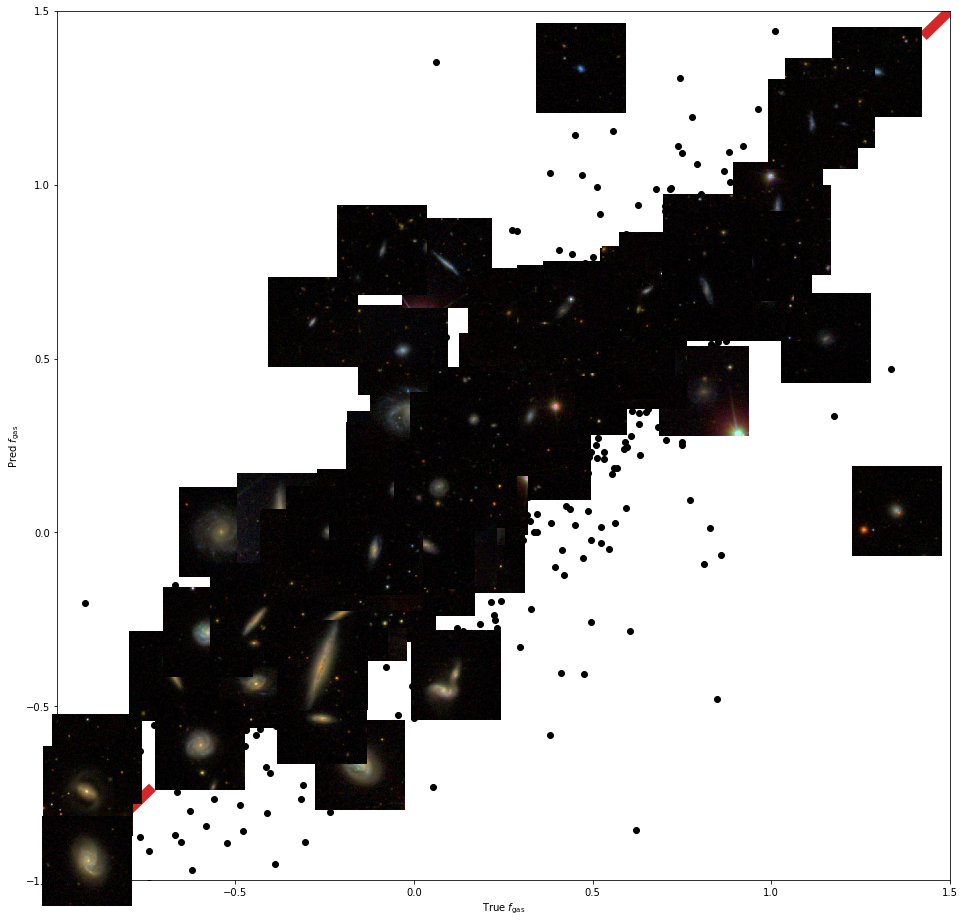

In [51]:
plot_results(results, show_images=True)